In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tanmays-sample-images/dem.jpg
/kaggle/input/tanmays-sample-images/Flood_Image_CHENIMARI_GAON (1).tif
/kaggle/input/tanmays-sample-images/river_segmentation.jpg
/kaggle/input/tanmays-sample-images/Elevation_CHENIMARI_GAON (1).tif
/kaggle/input/tanmays-sample-images/SAR_flooded.jpg
/kaggle/input/tanmays-sample-images/DEM.png
/kaggle/input/tanmays-sample-images/SAR_unflooded.jpg


# **Diffusion Model: $\pi-FM$**
* **Physics-AI based Flood Modeller**
* **Uses diffusion terms from topographical gradients to emulate regions with inundation....Laplace equation is used $\nabla^{2}V=k$**
* **Takes into account the water level of the river**
* **Does not take into account the flow parameters...will rely on Deep Learning for that**

# **Getting the samples ready**

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_unflooded = cv2.imread("/kaggle/input/tanmays-sample-images/SAR_unflooded.jpg",cv2.IMREAD_GRAYSCALE)
image_flooded = cv2.imread("/kaggle/input/tanmays-sample-images/SAR_flooded.jpg",cv2.IMREAD_GRAYSCALE)
dem = cv2.imread("/kaggle/input/tanmays-sample-images/DEM.png",cv2.IMREAD_GRAYSCALE)
river_segmentation = cv2.imread("/kaggle/input/tanmays-sample-images/river_segmentation.jpg",cv2.IMREAD_GRAYSCALE)

In [3]:
# normalizing and resizing
size = (256,256)
dem_ = dem[75:540,430:950] #its a figure not an image...so needs to be cropped
dem_ = cv2.resize(dem_,size)/255.0
river_segmentation = cv2.resize(river_segmentation,size)/255.0
image_unflooded = cv2.resize(image_unflooded,size)/255.0
image_flooded = cv2.resize(image_flooded,size)/255.0
result = cv2.addWeighted(dem_, 0.7,river_segmentation, 0.3, 0)


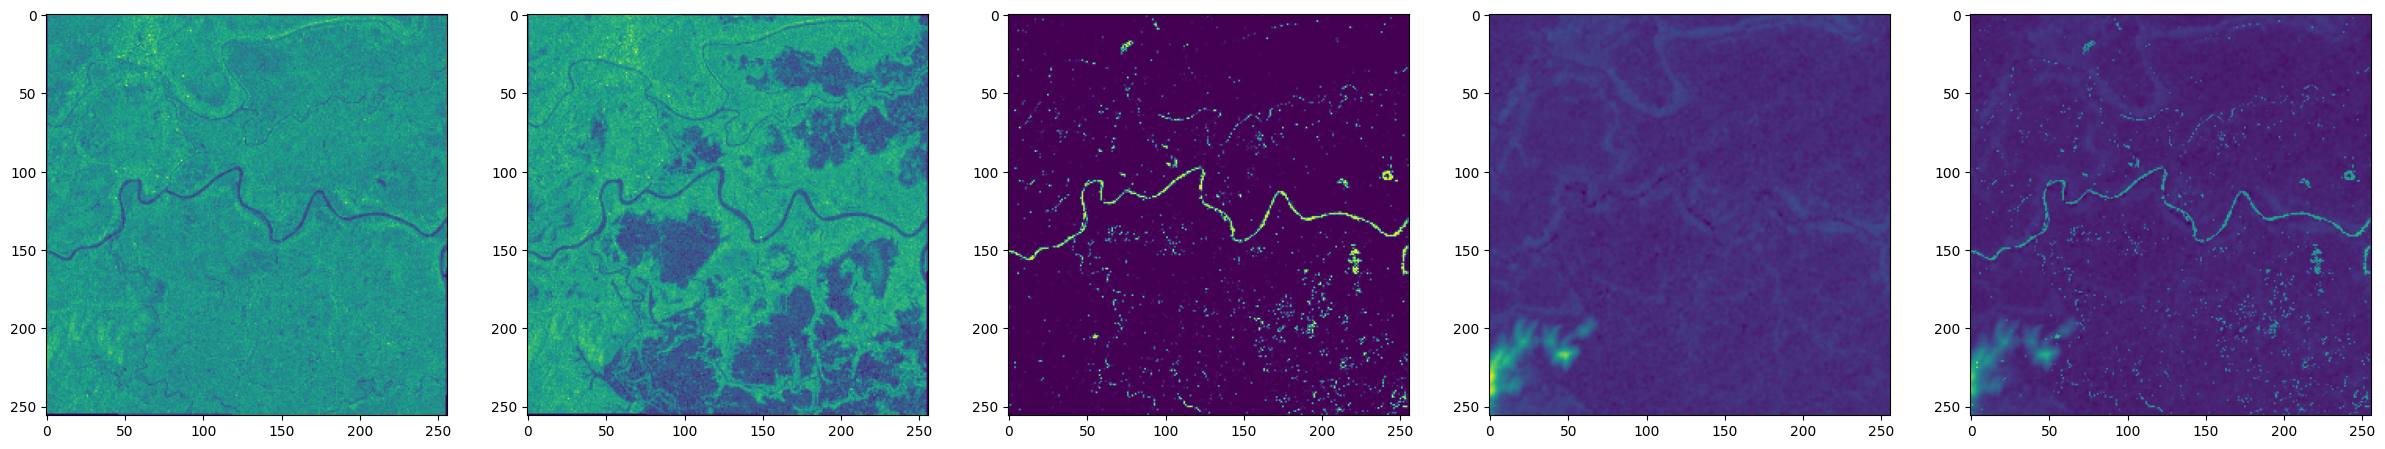

In [4]:
#plotting...sanity check
plt.figure(figsize=(30,6))
plt.subplot(1,5,1)
plt.imshow(image_unflooded)
plt.subplot(1,5,2)
plt.imshow(image_flooded)
plt.subplot(1,5,3)
plt.imshow(river_segmentation)
plt.subplot(1,5,4)
plt.imshow(dem_)
plt.subplot(1,5,5)
plt.imshow(result)
plt.show()

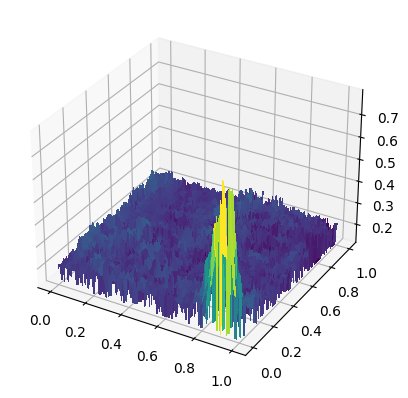

In [5]:
from mpl_toolkits.mplot3d import Axes3D


image_1 = dem_
image_2 = river_segmentation

# Set pixels in image_1 to np.min(image_1) where corresponding pixels in image_2 are positive
image_1[image_2 > 0] = np.min(image_1)

# Create a 3D surface plot of the modified image_1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N = 256
grid = np.zeros((N,N))
X, Y = np.mgrid[0:1:N*1j,0:1:N*1j]
z = image_1

# Plot surface
ax.plot_surface(X, Y, z, cmap='viridis',antialiased=False)

# Show the plot
plt.show()

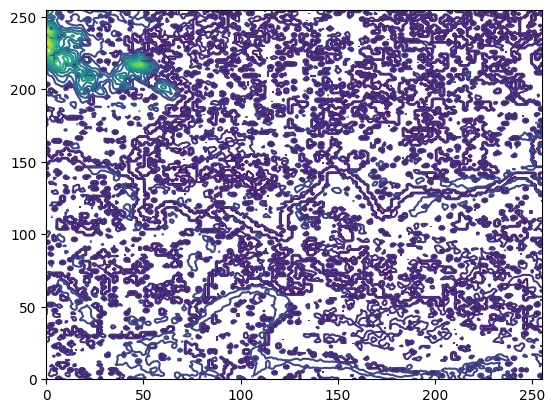

In [6]:
plt.contour(z, cmap='viridis',levels=15)
plt.show()

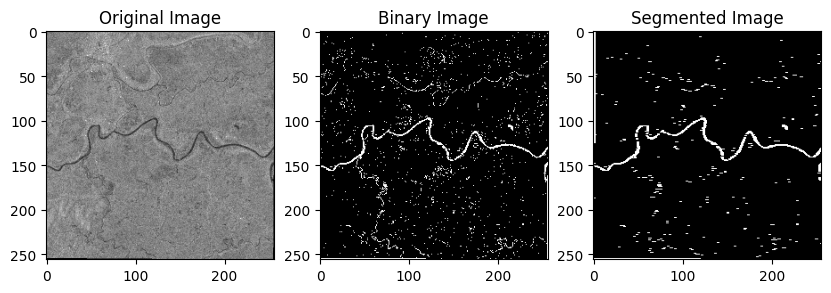

In [7]:
# my go on the river segmentation...i believe we are missing out the tributaries
image = image_unflooded

# Apply threshold to create a binary image
_, binary_image = cv2.threshold(image, 0.38, 1, cv2.THRESH_BINARY_INV)

# Apply morphological operations to enhance the features
kernel = np.ones((1, 2), np.uint8)
# Erosion to remove small noise or thin strands
erosion = cv2.erode(binary_image, kernel, iterations=1)
# Dilation to enhance and reconnect the river features
dilation = cv2.dilate(erosion, kernel, iterations=2)
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel=np.ones((1,1)), iterations=3)
# Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(binary_image, cmap='gray'), plt.title('Binary Image')
plt.subplot(1, 3, 3), plt.imshow(closing, cmap='gray'), plt.title('Segmented Image')
plt.show()

In [8]:
#not happy will go ahead with origial segmentation....I guess ill have to dilate the water channels

# Algorithm
* **Will use finite element method for solving $\nabla^{2}V=k$**
* **$k$ = rainfall parameter**
* **$Dirichilet$ and $Neumann$ boundary conditions applied**
* **$Dirichilet$ boundary condtions are updated based on the increasing water level parametrized by $\beta$**

In [9]:
#convolving element
from scipy.ndimage import convolve, generate_binary_structure
kern = generate_binary_structure(2,1).astype(float)/4
kern[1,1] = 0
kern

array([[0.  , 0.25, 0.  ],
       [0.25, 0.  , 0.25],
       [0.  , 0.25, 0.  ]])

In [10]:
#Boundary conditions
def apply_dirichilet(grid,image_2,image_1,min_elevation,beta):
    mask_water = image_2
    _, mask_ridge = cv2.threshold(image_1,np.mean(image_1)+beta, 255, cv2.THRESH_BINARY)
    grid[mask_water>0] = min_elevation
    grid[mask_ridge>0] = image_1[mask_ridge>0]
    return grid

def apply_neumann(grid,image_1):
    grid[0,:]  = grid[1,:]
    grid[-1,:] = grid[-2,:]
    grid[:,0] = grid[:,1]
    grid[:,-1] = grid[:,-2]
    return grid

# The water_level factor $(\beta)$
* **Im not refleting the increaing water on the water level of the river. Instead it is reflected on the relative elevation of the terrain**
* **basically $elevation\_map := elevation\_map - \beta$**

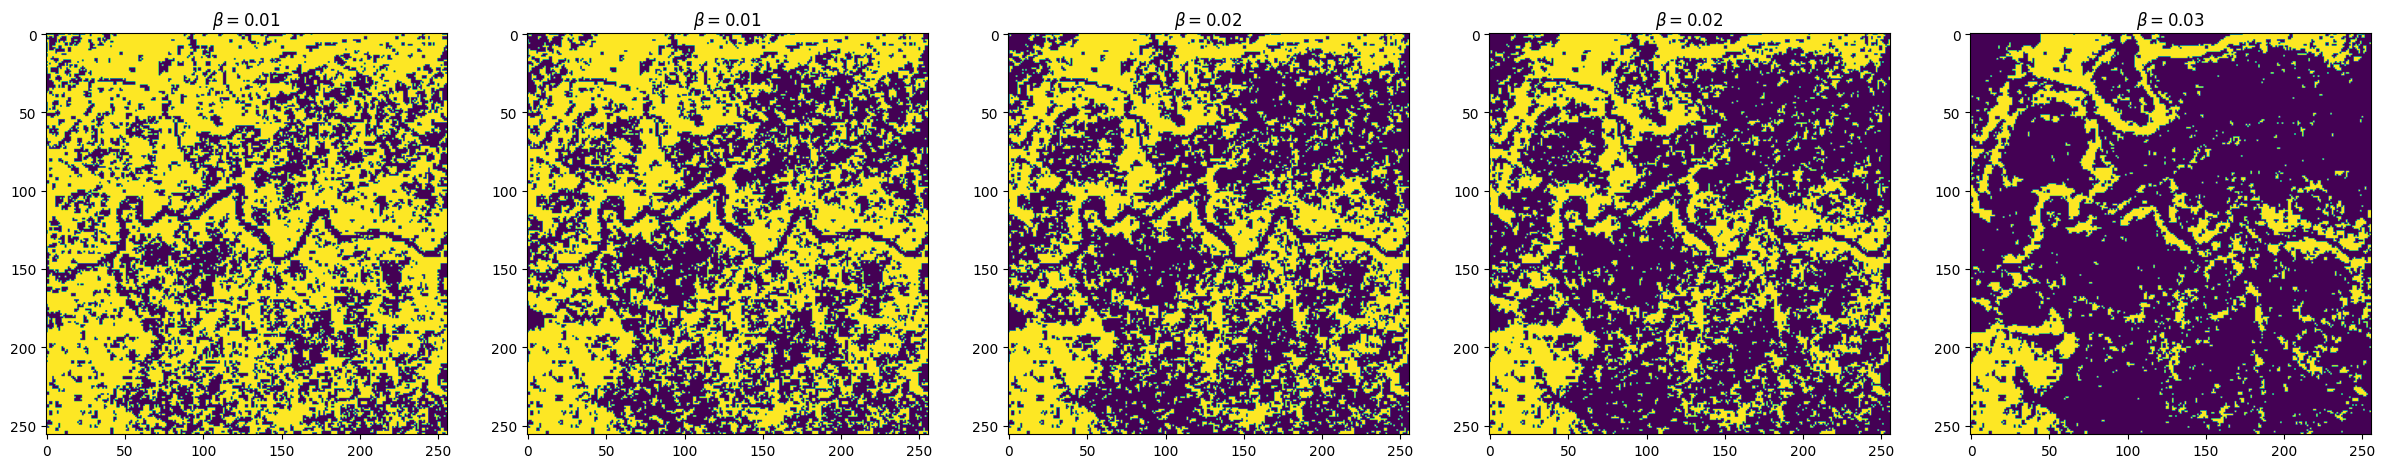

In [11]:
beta = 0.001
dw  = 0.005
iters = 5
plt.figure(figsize=(30,6))
for i in range(iters):
    _, binary_mask = cv2.threshold(dem_,np.mean(dem_)+beta, 255, cv2.THRESH_BINARY)
    beta = beta+dw
    plt.subplot(1,iters,i+1)
    plt.imshow(binary_mask)
    plt.title(r'$\beta = $'+f'{beta:.2f}')
    
plt.show()


# **Simulation**
**This simulation takes into accound the increasing water level**

In [12]:
def is_stable_state(err,threshold):
    if err >= threshold:
        return True
    else:
        return False

In [13]:
import math
from tqdm import tqdm
err = []
image_1 = dem_.copy()
image_2 = river_segmentation.copy()
min_elevation = np.min(image_1)
beta = 0.001 #water_level factor
dw = 0.00002 #increment_factor for water level
k = 0.000001 #rainfall_parameter
rainfall=False
stable_states = []
# jaha river hai value of elevation should always be min...must be enforced as dirichelet boundary condition as well
image_1[image_2 > 0] = np.min(image_1)

iters = 1000
grid = image_1.copy()
for i in tqdm(range(iters)):
    if(rainfall==True):
        grid_updated = 0.25 * (np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) + np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1)) - k
    else:
        grid_updated = convolve(grid,kern, mode='constant')
    err.append(np.mean((grid-grid_updated)**2))
    
    if i>=2 and is_stable_state(abs(err[-1]-err[-2]),0.00003):
        stable_states.append(grid_updated.copy())
    # Boundary conditions
    grid_updated = apply_dirichilet(grid_updated,image_2,image_1,min_elevation,beta)
    grid_updated = apply_neumann(grid_updated,image_1)
    grid = grid_updated
    beta = beta+dw

100%|██████████| 1000/1000 [00:02<00:00, 451.24it/s]


In [14]:
len(stable_states)

5

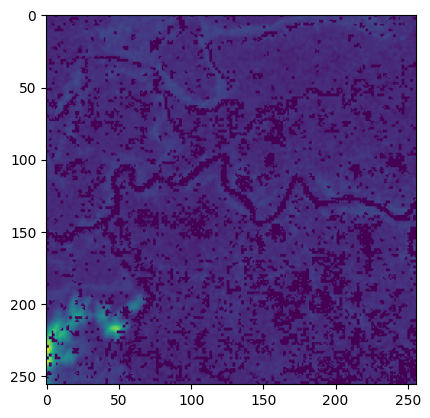

In [15]:
#sanity check...just to see if im not manipulating original matrices
plt.imshow(dem_)

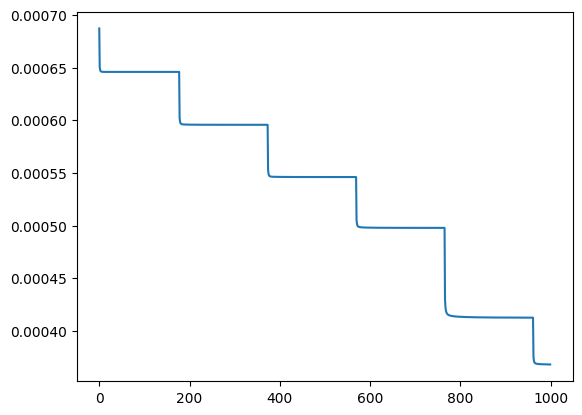

In [16]:
plt.plot(err)

* > It is clear that the flooding profile has certain stable states...wherin it evolves very slowly
* > These are the states that we are interested in
* > Mane simpleot for every water level computations kora necessary nohoi...system tur natural tendency ata ase to evolve into certain states

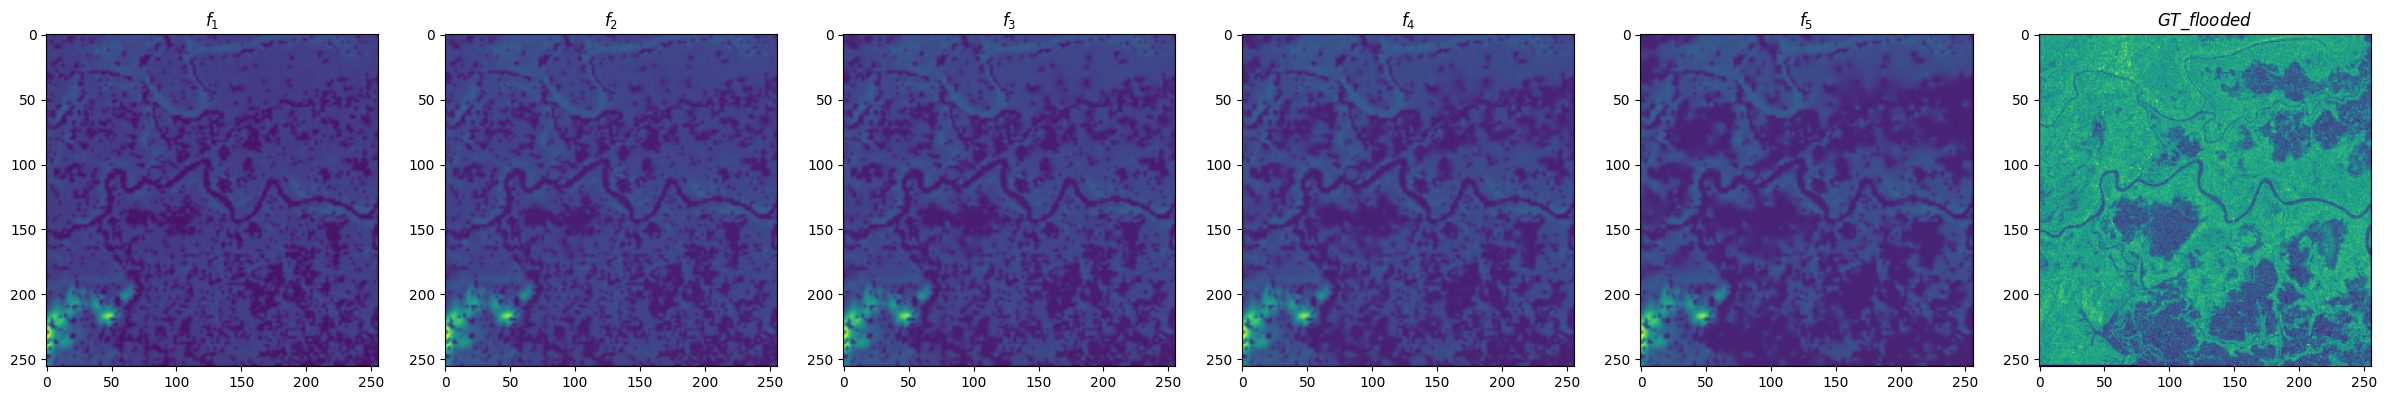

In [17]:
iters = len(stable_states)
plt.figure(figsize=(30,6))
for i in range(iters):
    plt.subplot(1,iters+1,i+1)
    plt.imshow(stable_states[i])
    plt.title(f'$f_{i+1}$')
    
plt.subplot(1,iters+1,iters+1)    
plt.imshow(image_flooded) 
plt.title('$GT\_flooded$')
plt.show()

# **Cluster generation**

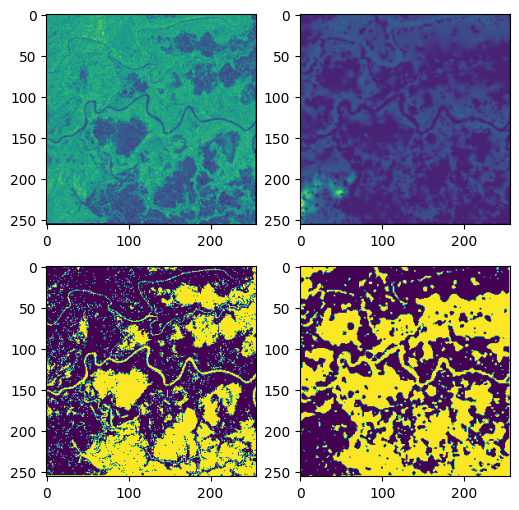

In [18]:
im1 = image_flooded
im2 = stable_states[-1]

"""
It seems ill have to introduce a compensation factor here...while iterating, beta is subtracted from the avg_dem_elevation..
so compensation factor (cf) = abs((im2)-np.mean(dem_))
"""
cf = abs(np.mean(im2)-np.mean(dem_))

t1 = np.mean(im1)
t2 = np.mean(im2) - cf/2
b1 = im1 <= t1
b2 = im2 <= t2

plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(im2)
plt.subplot(2,2,3)
plt.imshow(b1)
plt.subplot(2,2,4)
plt.imshow(b2)
plt.show()


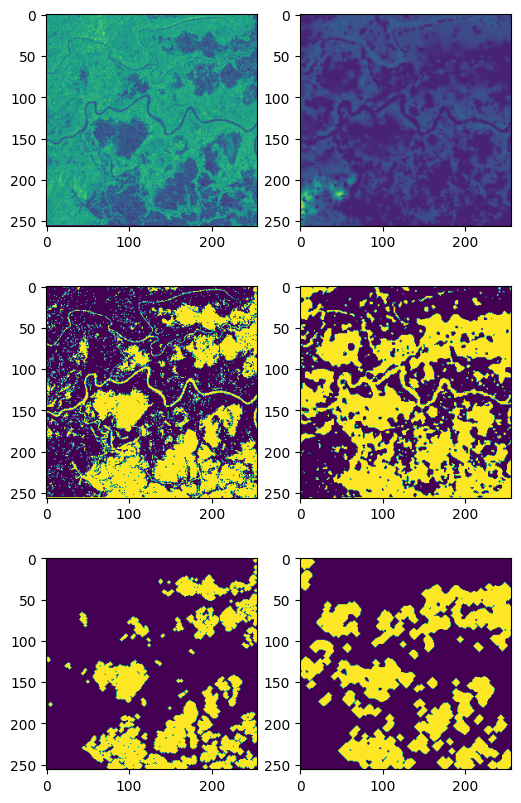

In [19]:
# Need to minimize holes using erosion and dialation
from scipy import ndimage

struct1 = ndimage.generate_binary_structure(2, 1)
struct2 = ndimage.generate_binary_structure(2, 2)

c1 = ndimage.binary_erosion(b1, structure=struct1,iterations=2).astype(np.float32)
c1 = ndimage.binary_dilation(c1, structure=struct1,iterations=2).astype(np.float32)


c2 = ndimage.binary_erosion(b2, structure=struct1,iterations=4).astype(np.float32)
c2 = ndimage.binary_dilation(c2, structure=struct1,iterations=4).astype(np.float32)


plt.figure(figsize=(6,10))
plt.subplot(3,2,1)
plt.imshow(im1)
plt.subplot(3,2,2)
plt.imshow(im2)
plt.subplot(3,2,3)
plt.imshow(b1)
plt.subplot(3,2,4)
plt.imshow(b2)
plt.subplot(3,2,5)
plt.imshow(c1)
plt.subplot(3,2,6)
plt.imshow(c2)
plt.show()



# K-Means for locating clusters

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def find_clusters(binary_image,num_clusters,image_flood):
    # Find the coordinates of positive pixels in the binary image
    positive_pixels = np.column_stack(np.where(binary_image == 1))
    
    #so far KMeans has produed the best result
    num_clusters = num_clusters 
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(positive_pixels)

    # Get the cluster labels and centroids
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    # Calculate distances from each point to its cluster center
    distances = cdist(positive_pixels, cluster_centroids)

    # Get the maximum distance for each cluster
    max_distances = np.max(distances, axis=0)

    # Plot the original binary image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_flooded)

    # Plot centroids and circles around clusters
    cluster_radius=[]
    for i in range(num_clusters):
        cluster_points = positive_pixels[cluster_labels == i]
        centroid = cluster_centroids[i]

        # Use the maximum distance as the radius
        radius = np.mean(cdist(cluster_points, [centroid])) + np.std(cdist(cluster_points, [centroid]))
        cluster_radius.append(radius)

        # Plot circle
        circle = plt.Circle((centroid[1], centroid[0]), radius, color='red', fill=False)
        plt.gca().add_patch(circle)

        # Plot centroid
        plt.scatter(centroid[1], centroid[0], color='red')

    plt.title('Centroids and Circles around Clusters (K-Means)')
    plt.show()
    return cluster_centroids,cluster_radius


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


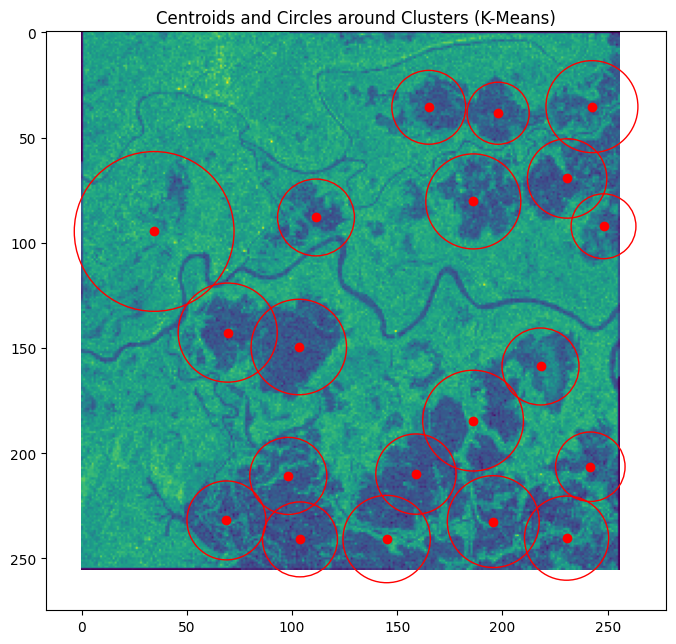

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


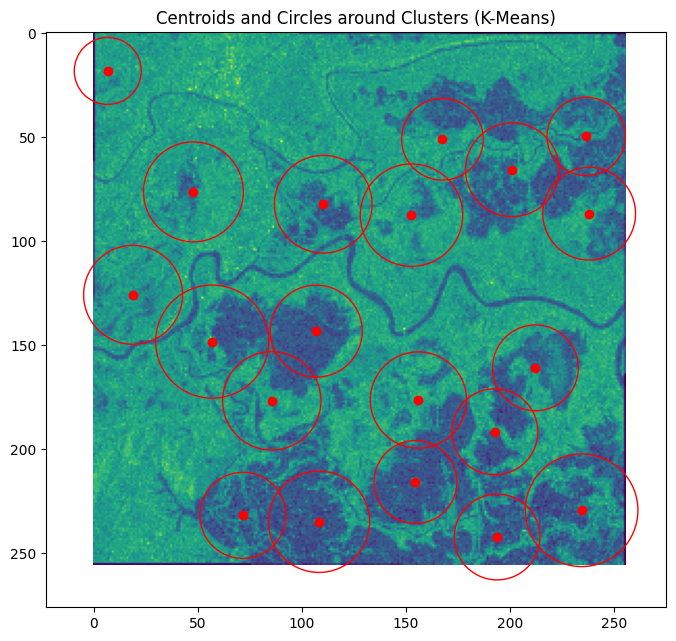

In [21]:
points_1,radius_1 = find_clusters(c1,20,image_flooded)#GT
points_2,radius_2  =find_clusters(c2,20,image_flooded)#predicted

# Generating Scores:

* **Based on distance from river**
* **Elevation**

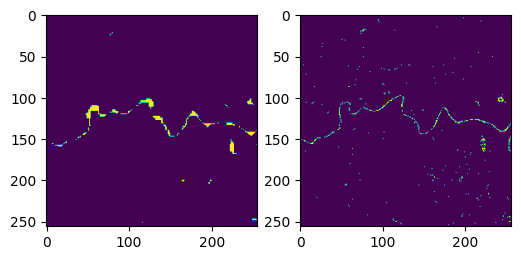

In [22]:
# I need to dilate the river segmentation mask to localize the water bodies
"""
this manipulation is not something Im very happy with this manipulation...but no other option
Im of the notion that we might have to train a DL model to segment the river
"""
struct1 = ndimage.generate_binary_structure(2, 1)
struct2 = ndimage.generate_binary_structure(2, 2)
struct3 = np.ones((2,10))
struct4=np.ones((1,2))
struct4 = cv2.getStructuringElement(1,(7,7))
#r1 = ndimage.binary_erosion(river_segmentation, structure=struct3,iterations=3).astype(np.float32)
r1 = ndimage.binary_dilation(river_segmentation>0.95, structure=struct4,iterations=2).astype(np.float32)
r1 = ndimage.binary_erosion(r1, structure=np.ones((2,2)),iterations=7).astype(np.float32)
#r1 = ndimage.binary_dilation(r1>0.95, structure=struct1,iterations=2).astype(np.float32)
#r1 = ndimage.binary_erosion(r1>0.95, structure=struct1,iterations=2).astype(np.float32)
#r1 = r1>0.99
plt.figure(figsize=(6,10))
plt.subplot(1,2,1)
plt.imshow(r1)
plt.subplot(1,2,2)
plt.imshow((river_segmentation>0.95).astype(np.uint8))

plt.show()

In [23]:
r1.shape

(256, 256)

In [24]:

def my_distance_algorithm(mask, point):
# this seems to work fine
# for each point go on increasing radius till u intersect a mask pixel->return radius (norm distance)
    radius = 1
    increment = 3
    
    while True:
        x,y = point
        circular_mask = np.zeros_like(mask, dtype=np.uint8)
        cv2.circle(circular_mask,(int(x),int(y)), int(radius), 1, thickness=1)
        intersection = cv2.bitwise_and(mask.astype(np.uint8), circular_mask)
        if cv2.countNonZero(intersection) > 0:
            distance_at_point = radius
            break

        radius += increment

    return distance_at_point
#sanity check
point = (100, 150)
distance = my_distance_algorithm(r1.astype(np.uint8), point)
print(f"Distance from River at Point {point}: {distance}")


Distance from River at Point (100, 150): 31


In [25]:
#sanity check
x, y = (10,10)
radius = 10
image = image_flooded
mask = np.zeros_like(image, dtype=np.uint8)
cv2.circle(mask, (x, y), radius, 1, thickness=cv2.FILLED)
circular_region = cv2.bitwise_and(image, image, mask=mask)

0.5473866518216118

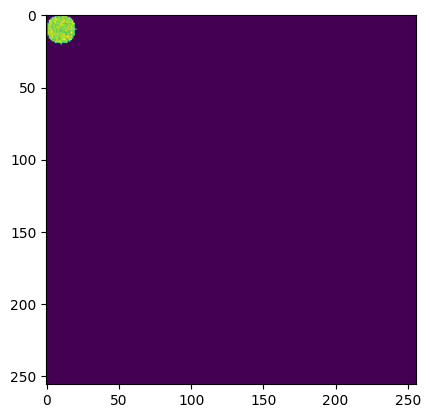

In [26]:
plt.imshow(circular_region)
np.mean(circular_region[circular_region > 0])

> * Mean pixel value is between [0,1]
> * Distances are >> 1
> * weighting needs to be done accordingly
> * **Score must be between [0,5]**


In [27]:
def calculate_score(image, points, radii, segmentation_mask):
    scores = []
    avg_pix_val = []
    dist_river = []
    
    for point, radius in zip(points, radii):
        # Extract a circular region around the point with the specified radius
        x, y = point
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.circle(mask, (int(x),int(y)), int(radius), 1, thickness=cv2.FILLED)#float me kaam nhiii krta 
        circular_region = cv2.bitwise_and(image, image, mask=mask)
        
        # Calculate average pixel value within the circular region
        temp1 = np.mean(circular_region[circular_region > 0])
        avg_pix_val.append(temp1)
        # Calculate distance from the river
        temp2 = my_distance_algorithm(segmentation_mask, point)
        dist_river.append(temp2)
        
    max_dist = np.max(dist_river)
    for p,d in zip(avg_pix_val,dist_river):
        w1 = 10
        w2 = 15
        
        # lets call it the Flooding_Index 
        score = 5.0 + (p * w1) - ((d/max_dist) * w2) #p and d/d_max lies in [0,1] hence w =10
        score = max(0.0, min(score, 5.0))
        scores.append(score)
        

    
    return scores

In [28]:
x, y = points_1[0]

In [29]:
x,y

(142.67032967032992, 69.41147741147553)

In [30]:
scores_1 = calculate_score(image_unflooded,points_1,radius_1,segmentation_mask=r1)
scores_2 = calculate_score(image_unflooded,points_2,radius_2,segmentation_mask=r1)

In [31]:
scores_1

[2.5587200987842067,
 5.0,
 0.0,
 5.0,
 5.0,
 0.0,
 5.0,
 0.20682390290351904,
 2.7043225034943763,
 2.349293758205473,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 2.4005635119205033,
 5.0,
 4.8624967475843315]

In [32]:
#Plotting function
def plot_circles_with_scores(image, points, radii, segmentation_mask,scores):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for point, radius, score in zip(points, radii, scores):
        x, y = point
        #x, y = int(x), int(y)
        
        # Determine the color based on the score
        color = (score / 5.0, 0, 1.0 - score / 5.0)  # Bluish to reddish gradient
        
        # Plot circle
        circle = plt.Circle((x, y), radius, color=color, fill=False)
        plt.gca().add_patch(circle)
        
        # Plot centroid
        plt.scatter(x, y, color=color)
    
    plt.title('Regions with Scores')
    plt.show()

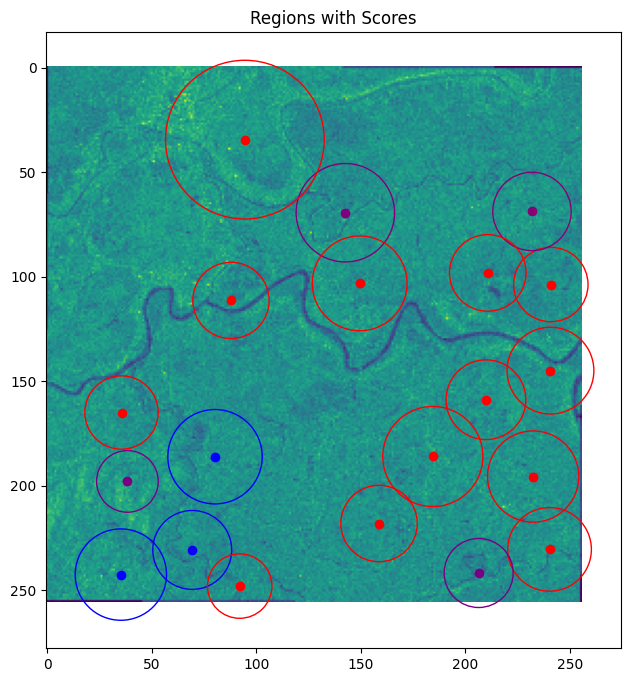

In [33]:
plot_circles_with_scores(image_unflooded,points_1,radius_1,r1,scores_1)

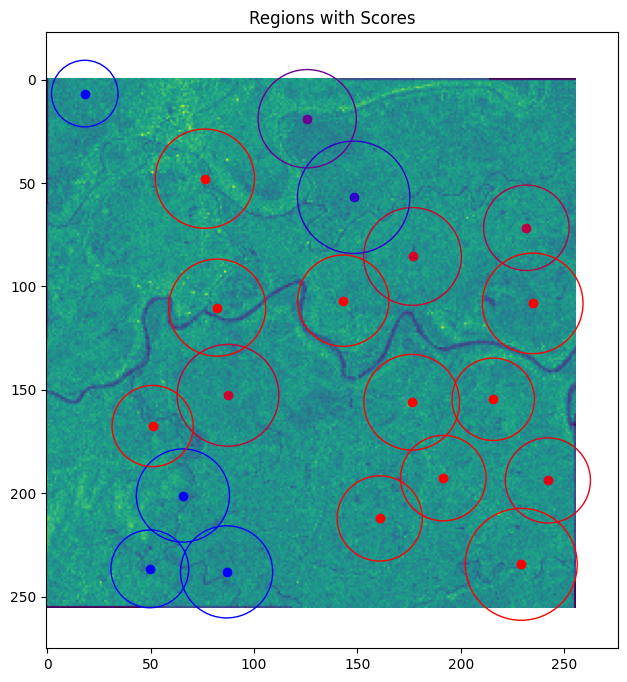

In [34]:
plot_circles_with_scores(image_unflooded,points_2,radius_2,r1,scores_2)

# Integration of AI